### Ejercicios del tema de Clasificación

*Hugo Díaz Díaz* (*hdiazd00@estudiantes.unileon.es*)

*Correo profesional: hugo.didi.contacto@gmail.com*

---

> 
> En este cuaderno encontrarás:
>- La construcción de un **clasificador para el dataset MNIST** con exactitud igual o superior al 97%.
>- La realización de **Data Augmentation** sobre este conjunto de datos.
>- ***(OPCIONAL)*** La creación de un modelo de predicción de supervivencia sobre el dataset del *Titanic*.
> 

---


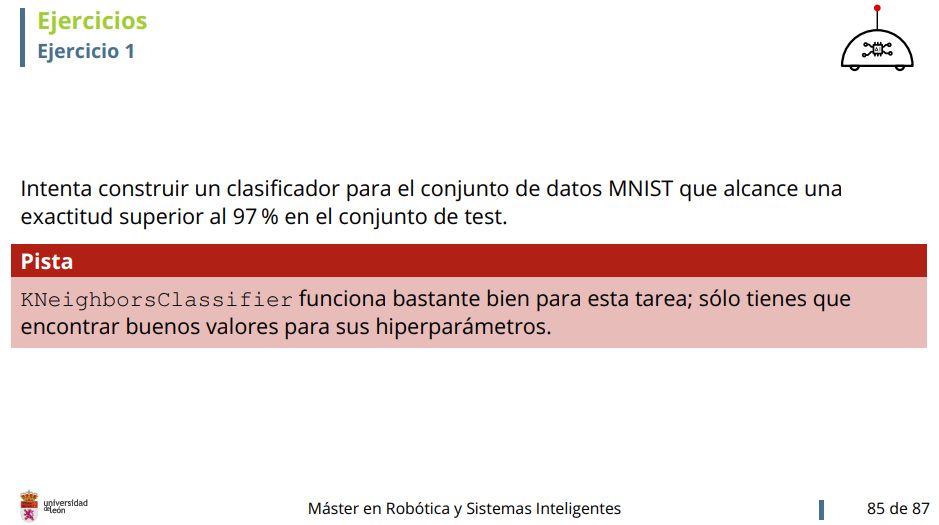

### 1.1. Configuración inical y carga del dataset
Podemos empezar con el bloque inicial, tal como explica el profesor, verificando las versiones de Python y Scikit. Después, cargando las librerías comunes y configurando el guardado de gráficos.

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Ahora, cargamos el dataset de trabajo MNIST.

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)

ImportError: Using `parser='auto'` with dense data requires pandas to be installed. Alternatively, explicitly set `parser='liac-arff'`.

### 1.2. Preparación de los datos.
Se decide normalizar para que la presencia de pixeles negros o muy altos (valores cercanos a 255), no presenten excesiva influencia en el cálculo de distancias del KNN.

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

X_train = X_train.astype(np.float32)/ 255.0
X_test = X_test.astype(np.float32)/ 255.0

### 1.3. Entrenamiento del modelo (KNN) y test

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=4, weights='distance', p=2) #distancia euclídea
knn_clf.fit(X_train, y_train)

,n_neighbors,4
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


Ahora extraemos el `cross_val_score()`

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cross_val_score(knn_clf, X_train, y_train, cv=skfolds, scoring="accuracy")

array([0.9738, 0.9727, 0.9706])

De esta manera, se ha logrado superar el **97% de accuracy**. Se decidió usar 4 vecinos ya que el resultado de accuracy era ligeramente más estable.

Por jugar un poco, hagamos una herramienta de rapida de test de imágenes. Esta herramienta elige un *datapoint* reservado para test aleatorio, muestra la imagen, e imprime el valor esperado y predicho por el modelo.

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

i = np.random.randint(len(X_test))
some_digit = X_test[i]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()
print("Valor esperado:", y_test[i], "\tValor predicho:", knn_clf.predict([some_digit]))

NameError: name 'X_test' is not defined

---

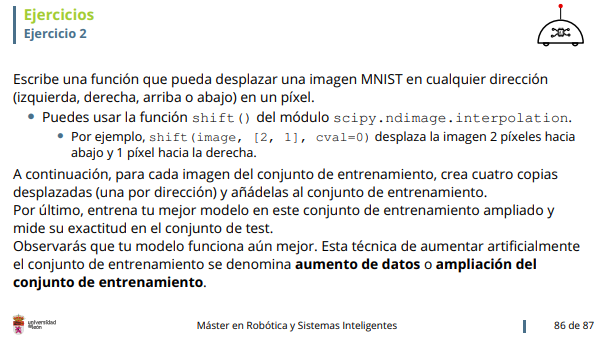

### 2.1. Creación de la función de desplazamiento de la imagen.

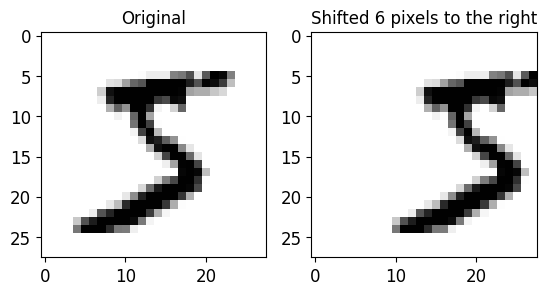

In [ ]:
from scipy.ndimage import shift

def shift_image(image, direction, multiplier=1):
    if direction == 'left':
        shifted_image = shift(image.reshape(28, 28), [0, -1 * multiplier], cval=0)
    elif direction == 'right':  
        shifted_image = shift(image.reshape(28, 28), [0, 1 * multiplier], cval=0)    
    elif direction == 'up':
        shifted_image = shift(image.reshape(28, 28), [-1 * multiplier, 0], cval=0)   
    elif direction == 'down':
        shifted_image = shift(image.reshape(28, 28), [1 * multiplier, 0], cval=0)    
    else:
        raise ValueError("Direction must be 'left', 'right', 'up' or 'down'")
    return shifted_image.reshape(784)

# Ejemplo: mover 3 píxeles a la derecha
multiplier=6
direction='right'
shifted_image = shift_image(X[0], direction=direction, multiplier=multiplier)

plt.subplot(1, 2, 1)
plt.imshow(X[0].reshape(28, 28), cmap=mpl.cm.binary)
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(shifted_image.reshape(28, 28), cmap=mpl.cm.binary)
plt.title("Shifted {} pixels to the {}".format(multiplier, direction))

plt.show()


Hecho, ya podemos desplazar las imágenes en cualquier dirección y una cantidad de píxeles elegida (para que fuera más fácil de ver en el ejemplo).

### 2.2. Implementación de Data Augmentation

Ahora automatizamos 4 versiones desplazadas un píxel en cada dirección para cada dato de entrenamiento. Finalmente se añaden al conjunto de entrenamiento global.

In [ ]:
X_train.shape, y_train.shape

((60000, 784), (60000,))

In [ ]:
X_train_augmented = [X_train.copy()]
y_train_augmented = [y_train.copy()]
for direction in ('left', 'right', 'up', 'down'):
    shifted_images = np.array([shift_image(image, direction=direction) for image in X_train])
    X_train_augmented.append(shifted_images)
    y_train_augmented.append(y_train)

X_train_augmented = np.concatenate(X_train_augmented)
y_train_augmented = np.concatenate(y_train_augmented)

X_train_augmented.shape, y_train_augmented.shape

((300000, 784), (300000,))

Genial, ahora hemos aumentado el tamaño del conjunto de entrenamiento de 60000 a 300000 datos. Comprobemos rápidamente si mejora la efectividad del modelo.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

knn_clf_2 = KNeighborsClassifier(n_neighbors=4, weights='distance', p=2) #distancia euclídea
knn_clf_2.fit(X_train_augmented, y_train_augmented)

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cross_val_score(knn_clf_2, X_train_augmented, y_train_augmented, cv=skfolds, scoring="accuracy")


array([0.98352, 0.98381, 0.98307])

Tras 18 minutos de entrenamiento + validación cruzada se verifica que un modelo igual al original, entrenado con este nuevo conjunto de datos, gana algo más de exactitud en la clasificación, aproximadamente un 98.3%. Esto demuestra el efecto positivo de realizar Data Augmentation para este caso.

---

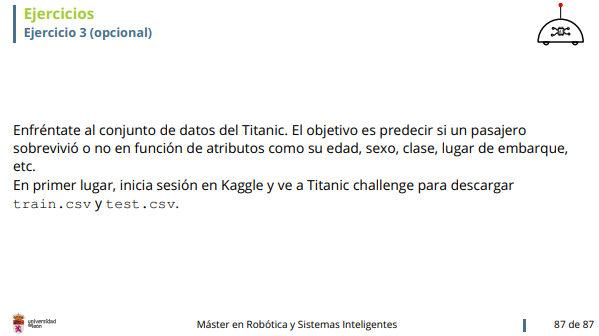

### 3.1. Pasos preliminares.

Una vez descargado, cargamos los datos y hacemos unas comprobaciones previas para comprender mejor el dataset.

In [ ]:
import pandas as pd
df_train = pd.read_csv("../data/titanic_train.csv")
df_test = pd.read_csv("../data/titanic_test.csv")
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Vemos el tamaño de ambos conjuntos.

In [ ]:
df_train.shape, df_test.shape

((891, 12), (418, 11))

Con esto, vamos a aclarar que forma deben tener los datapoints de trabajo.

$$Características = [EDAD, SEXO, CLASE, LUGAR_{EMBARQUE}] $$
$$Etiquetas = [SUPERVIVENCIA]$$

De esta manera, se pueden separar características y etiquetas.

In [ ]:
X_train = df_train[["Age", "Sex", "Pclass", "Embarked"]]
y_train = df_train["Survived"].astype(int)
X_test = df_test[["Age", "Sex", "Pclass", "Embarked"]]

Separamos ahora variables numéricas y categóricas para el entrenamiento.

In [ ]:
num_cols = ["Age", "Pclass"]
cat_cols = ["Sex", "Embarked"]

Xtr_num = X_train[num_cols].copy()
Xte_num = X_test[num_cols].copy()

Xtr_cat = X_train[cat_cols].copy()
Xte_cat = X_test[cat_cols].copy()


### 3.2. Imputación
En el dataset existen muchos datos faltantes (p.ej: la edad de muchos pasajeros). Para solventarlo, utilizaremos mecanismos de imputación:
- Para las variables numéricas, utilizaremos la mediana para rellenar huecos.
- Para las variables categóricas, utilizaremos la moda. 

In [ ]:
from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

Xtr_num_imp = num_imputer.fit_transform(Xtr_num)   # aprende y aplica mediana en train
Xte_num_imp = num_imputer.transform(Xte_num)       # aplica al test

Xtr_cat_imp = cat_imputer.fit_transform(Xtr_cat)   # aprende y aplica moda en train
Xte_cat_imp = cat_imputer.transform(Xte_cat)       # aplica al test

### 3.3. One Hot Encoding
Para facilitar el entendimiento de las variables categóricas por el modelo, se utiliza la técnica de one hot encoding, que convierte cada variable en un vector único de 0 y 1 (normalmente un vector de rango equivalente al número de variables categóricas con un único 1 en la posición adjudicada a la variable).


In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False) 
Xtr_cat_ohe = ohe.fit_transform(Xtr_cat_imp)      # ajusta categorías con train
Xte_cat_ohe = ohe.transform(Xte_cat_imp)          # aplica las mismas columnas al test

# Obtener nombres de columnas generadas

ohe_cols = ohe.get_feature_names_out(cat_cols)

Xtr_cat_ohe = pd.DataFrame(Xtr_cat_ohe, columns=ohe_cols, index=X_train.index)
Xte_cat_ohe = pd.DataFrame(Xte_cat_ohe, columns=ohe_cols, index=X_test.index)


### 3.4 Unión y entrenamiento

In [ ]:
# Convertir numéricas imputadas en DataFrame
Xtr_num_imp = pd.DataFrame(Xtr_num_imp, columns=num_cols, index=X_train.index)
Xte_num_imp = pd.DataFrame(Xte_num_imp, columns=num_cols, index=X_test.index)

# Unir numéricas y categóricas
Xtr_final = pd.concat([Xtr_num_imp, Xtr_cat_ohe], axis=1)
Xte_final = pd.concat([Xte_num_imp, Xte_cat_ohe], axis=1)

print("Shape final train:", Xtr_final.shape)
print("Shape final test :", Xte_final.shape)
print("Columnas finales:", list(Xtr_final.columns))


Shape final train: (891, 7)
Shape final test : (418, 7)
Columnas finales: ['Age', 'Pclass', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']


Antes de hacer la predicción final del conjunto de test, evaluamos la eficiencia de un modelo Random Forest para una fracción del conjunto de entrenamiento (ya que si cuentan con resultado de supervivencia conocida, al contrario de los datos de test).

In [ ]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(
    Xtr_final, y_train, test_size=0.2, stratify=y_train, random_state=42
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_tr, y_tr)
val_pred = rf.predict(X_val)
print("Accuracy:", accuracy_score(y_val, val_pred))


Accuracy: 0.7988826815642458


Obtenemos un 80% de accuracy, lo cuál no está mal dada la cantidad considerable de datos faltantes en algunas categorías, la exclusión de otras también importantes como "familia a bordo" y el tamaño reducido del dataset. Finalmente entrenamos el modelo con todo el conjunto de entrenamiento y extraemos el reporte de predicciones para los sujetos de test en CSV.

In [ ]:
rf.fit(Xtr_final, y_train)
test_pred = rf.predict(Xte_final)

# Crear el archivo de reporte de predicciones
import os

submission = pd.DataFrame({"PassengerId": df_test["PassengerId"], "Survived": test_pred.astype(int)})
print("survival_submission.csv generado")

# crear carpeta ../output si no existe
os.makedirs("../output", exist_ok=True)

# guardar el archivo ahí
submission.to_csv("../output/submission.csv", index=False)
print("Archivo guardado en ../output")


survival_submission.csv generado
Archivo guardado en ../output


In [ ]:
predictiondata = pd.read_csv("../output/submission.csv")
predictiondata.head(418)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
